In [151]:
import os
import re
import pandas as pd
import numpy as np
import sys
import glob
import traceback
import json
import folium

sys.path.append('/lib')
import lib.helper as helper

%matplotlib inline
# %load_ext folium_magic

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/data'
RAW_DATA_DIR = DATA_DIR + '/raw'
ANALYSES_DIR = "data/analyses/"
MAPS_DIR = DATA_DIR + "/maps"
UK_REGIONS_FILE = CURRENT_DIR + '/lib/UK-regions.json'

In [152]:
# Absolute or relative path to workshop data extracted from AMY
workshops_file = "data/processed/processed_carpentry_workshops_UK_2020-12-08_redash.csv"

In [153]:
workshops_df = pd.read_csv(workshops_file, encoding = "utf-8")

workshops_df.rename(columns={"venue": "institution"}, inplace=True)
# Add column 'description' which is used in popups in maps
workshops_df['popup'] = np.where(workshops_df["address"].empty, workshops_df["institution"],
                                               workshops_df["institution"] + ', ' + workshops_df["address"])

In [154]:
# Let's inspect our data
workshops_df.head(5)

,slug,year,start,end,attendance,country,region,country_code,organiser,organiser_web_domain,...,address,longitude,latitude,workshop_type,workshop_subtype,workshop_status,tags,website_url,workshop_domains,popup
0,2020-12-07-NCL-SWC-ONLINE,2020.0,2020-12-07,2020-12-11,0,United Kingdom,North East,GB,University of Newcastle,ncl.ac.uk,...,online,-1.000000,45.000000,SWC,NaN,NaN,"['SWC', 'online']",https://nclrse-training.github.io/2020-12-07-N...,NaN,"University of Newcastle, online"
1,2020-12-01-edinburgh-bio-online,2020.0,2020-12-01,2020-12-15,0,United Kingdom,Scotland,GB,University of Edinburgh,ed.ac.uk,...,Zoom,-3.187239,55.947459,NaN,Circuits,NaN,['Circuits'],https://edcarp.github.io/2020-12-01-edinburgh-...,NaN,"University of Edinburgh, Zoom"
2,2020-11-25-rslondon,2020.0,2020-11-25,2020-11-27,0,United Kingdom,London,GB,University College London,ucl.ac.uk,...,Online,-123.393333,-48.876667,SWC,NaN,NaN,['SWC'],https://rslondon.github.io/2020-11-25-rslondon/,NaN,"Research Software London, Online"
3,2020-11-25-edinburgh-dc-digital-humanities,2020.0,2020-11-25,2020-11-27,0,United Kingdom,Scotland,GB,University of Edinburgh,ed.ac.uk,...,online,-123.393333,-48.876667,DC,NaN,NaN,['DC'],https://edcarp.github.io/2020-11-25-edinburgh-...,NaN,"University of Edinburgh, online"
4,2020-11-23-swansea,2020.0,2020-11-23,2020-11-27,0,United Kingdom,Wales,GB,Swansea University,swansea.ac.uk,...,online,-3.900000,51.700000,DC,NaN,NaN,"['DC', 'online']",http://sa2c.github.io/2020-11-23-swansea,NaN,"Swansea University (online), online"


In [164]:
# Let's inspect our data
workshops_df.tail(5)

,slug,year,start,end,attendance,country,region,country_code,organiser,organiser_web_domain,...,address,longitude,latitude,workshop_type,workshop_subtype,workshop_status,tags,website_url,workshop_domains,popup
358,2012-10-22-newcastle,2012.0,2012-10-22,2012-10-23,31,United Kingdom,North East,GB,University of Newcastle,ncl.ac.uk,...,NaN,-1.614614,54.980095,SWC,NaN,NaN,['SWC'],https://swcarpentry.github.io/2012-10-22-newca...,NaN,NaN
359,2012-09-13-dafx,2012.0,2012-09-13,2012-09-14,33,United Kingdom,Yorkshire and The Humber,GB,University of York,york.ac.uk,...,University of York,-1.052914,53.948193,SWC,NaN,NaN,['SWC'],https://swcarpentry.github.io/2012-09-13-dafx/,NaN,"University of York, University of York"
360,2012-07-10-ral,2012.0,2012-07-10,2012-07-12,24,United Kingdom,South East,GB,Science & Technology Facilities Council,stfc.ac.uk,...,,-1.314722,51.573333,SWC,NaN,NaN,['SWC'],,NaN,"Rutherford Appleton Laboratory,"
361,2012-05-14-newcastle,2012.0,2012-05-14,2012-05-15,41,United Kingdom,North East,GB,University of Newcastle,ncl.ac.uk,...,,-1.614614,54.980095,SWC,NaN,NaN,['SWC'],https://swcarpentry.github.io/2012-05-14-newca...,NaN,"Newcastle University,"
362,2012-04-30-ucl,2012.0,2012-04-30,2012-05-01,44,United Kingdom,London,GB,University College London,ucl.ac.uk,...,,-0.133458,51.559882,SWC,NaN,NaN,['SWC'],https://swcarpentry.github.io/2012-04-30-ucl/,NaN,"University College London,"


      number_of_workshops
year                     
2012                    7
2013                   14
2014                   20
2015                   31
2016                   40
2017                   52
2018                   61
2019                   85
2020                   53

Total workshops 363



<AxesSubplot:title={'center':'Workshops per year'}, xlabel='year'>

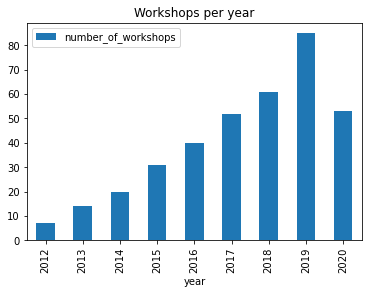

In [187]:
# How many workshops are there for each year?
workshops_per_year = workshops_df['year'].value_counts()
workshops_per_year.sort_index(ascending = True, inplace=True)
workshops_per_year.index.name = 'year'
workshops_per_year.index = workshops_per_year.index.astype('int64')
workshops_per_year = workshops_per_year.to_frame('number_of_workshops')
print(workshops_per_year)
print()
total_workshops = workshops_per_year['number_of_workshops'].sum()
print("Total workshops " + str(total_workshops))
print()
workshops_per_year.plot(kind='bar', legend=True, title ="Workshops per year")

workshop_type  DC  LC  SWC  TTT
year                           
2012            0   0    7    0
2013            0   0   14    0
2014            0   0   20    0
2015            2   1   24    4
2016            7   0   30    3
2017           12   2   33    5
2018           11   2   43    5
2019           24   3   54    4
2020           15   0   29    2


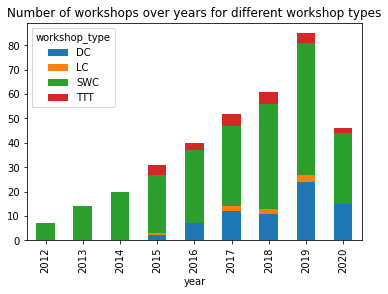

In [188]:
# How are numbers of different workshops (SWC, DC, LC, TTT) changing over years?
workshops_per_type_per_year = workshops_df.groupby(['workshop_type', 'year'])['workshop_type'].count().unstack('workshop_type').fillna(0).astype(dtype='int')
workshops_per_type_per_year.index = workshops_per_type_per_year.index.astype('int64')
workshops_per_type_per_year.plot(kind='bar', stacked=True, title="Number of workshops over years for different workshop types")
print(workshops_per_type_per_year)

workshop_type
LC       8
TTT     23
DC      71
SWC    254
dtype: int64


<AxesSubplot:title={'center':'Total number of workshops of different types'}, xlabel='workshop_type'>

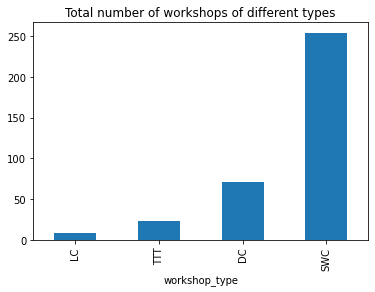

In [189]:
# Total number of workshops of different types?
total_workshops_per_type = workshops_per_type_per_year.sum(axis=0).sort_values()
print(total_workshops_per_type)
total_workshops_per_type.plot(kind='bar', title="Total number of workshops of different types")

               number_of_workshops
workshop_type                     
SWC                            254
DC                              71
TTT                             23
LC                               8


<AxesSubplot:title={'center':'Number of workshops for different workshop types'}, xlabel='workshop_type'>

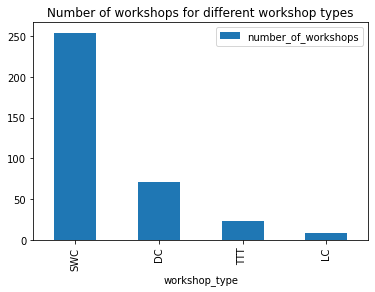

In [190]:
# How many of SWC, DC, LC, TTT workshops each were held so far?
workshops_per_type = workshops_df['workshop_type'].value_counts()
workshops_per_type.index.name = 'workshop_type'
workshops_per_type = workshops_per_type.to_frame('number_of_workshops')
print(workshops_per_type)
workshops_per_type.plot(kind='bar', legend=True, title ="Number of workshops for different workshop types")

Number of online workshops: 41
Number of in-person workshops: 322


<AxesSubplot:title={'center':'Online vs in-person workshops'}>

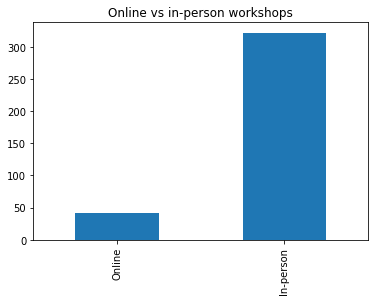

In [191]:
# Online vs in-person workshops
online_workshops = workshops_df[workshops_df['tags'].str.contains('online')]['tags'].count()
inperson_workshops = total_workshops - online_workshops
print("Number of online workshops: " + str(online_workshops))
print("Number of in-person workshops: " + str(inperson_workshops))
online_vs_inperson_workshops = pd.Series([online_workshops, inperson_workshops])
online_vs_inperson_workshops.index = ['Online', 'In-person']
online_vs_inperson_workshops = online_vs_inperson_workshops.astype(int)
online_vs_inperson_workshops.plot(kind='bar', legend=False, title ="Online vs in-person workshops")

In [192]:
# Let's just look at Instructor Training workshops ("TTT")
workshops_df[workshops_df['workshop_type'] == 'TTT'][['slug', 'organiser']]

,slug,organiser
19,2020-09-08-ttt-ssi-online,SSI Software Sustainability Institute
30,2020-05-28-ttt-edinburgh,SSI Software Sustainability Institute
68,2019-10-31-ttt-Imperial,Imperial College London
75,2019-10-08-ttt-manchester,University of Manchester
78,2019-09-25-ttt-leeds,University of Leeds
134,2019-01-22-ttt-online-westeurope,Instructor Training
151,2018-11-05-ttt-online,Software Carpentry
155,2018-10-09-ttt-online,SSI Software Sustainability Institute
174,2018-05-24-ttt-online,Software Carpentry
183,2018-04-18-ttt-leeds,University of Leeds


ed.ac.uk                  46
ucl.ac.uk                 39
manchester.ac.uk          34
imperial.ac.uk            22
elixir-uk.org             19
leeds.ac.uk               18
ox.ac.uk                  15
southampton.ac.uk         15
cam.ac.uk                 11
swansea.ac.uk             11
st-andrews.ac.uk          11
bham.ac.uk                10
kcl.ac.uk                  9
earlham.ac.uk              9
aber.ac.uk                 8
ncl.ac.uk                  5
epcc.ed.ac.uk              5
bristol.ac.uk              4
anthro.ox.ac.uk            4
software.ac.uk             4
tgac.ac.uk                 3
hw.ac.uk                   3
ukaea.uk                   3
carpentries.org            3
qmul.ac.uk                 3
dundee.ac.uk               3
shef.ac.uk                 3
crick.ac.uk                2
software-carpentry.org     2
nhm.ac.uk                  2
exeter.ac.uk               2
gla.ac.uk                  2
qub.ac.uk                  2
york.ac.uk                 2
stfc.ac.uk    

<AxesSubplot:title={'center':'Workshops per host'}>

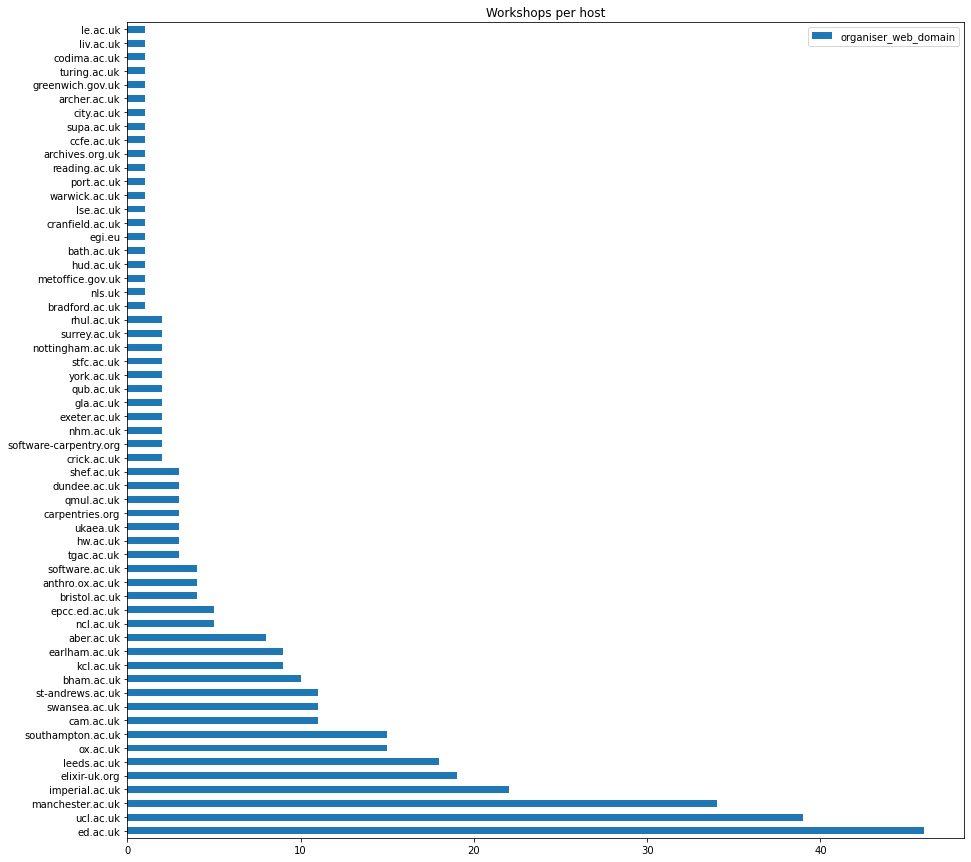

In [193]:
# How many workshops were held at each host institution?
workshops_per_host = workshops_df['organiser_web_domain'].value_counts()
print(workshops_per_host)
workshops_per_host.plot(kind='barh', legend=True, title ="Workshops per host", figsize = (15,15))

In [194]:
# How many workshops have been held at each instituion each year?
# Remove rows with NaN value for the institution
workshops_df = workshops_df.dropna(subset=['organiser_web_domain'])

workshops_per_host_per_year = pd.core.frame.DataFrame(
    {'number_of_workshops': workshops_df.groupby(['organiser_web_domain', 'year']).size()}).reset_index()
workshops_per_host_per_year_pivot = workshops_per_host_per_year.pivot_table(index='organiser_web_domain', columns='year')
# workshops_per_host_per_year_pivot.columns.levels[1] = workshops_per_host_per_year_pivot.columns.levels[1].astype(str)

# print(workshops_per_host_per_year_pivot.columns)
multi_index = workshops_per_host_per_year_pivot.columns 
workshops_per_host_per_year_pivot.columns = multi_index.set_levels(multi_index.levels[1].astype(int), level = 1) # set column names to be integers and not floats
# print(workshops_per_host_per_year_pivot.columns)

workshops_per_host_per_year_pivot = workshops_per_host_per_year_pivot.fillna(0).astype('int')
workshops_per_host_per_year_pivot

number_of_workshops                                     \
year                                  2012 2013 2014 2015 2016 2017 2018 2019   
organiser_web_domain                                                            
aber.ac.uk                               0    0    0    0    0    0    3    2   
anthro.ox.ac.uk                          0    0    0    0    0    3    1    0   
archer.ac.uk                             0    0    0    0    0    0    0    1   
archives.org.uk                          0    0    0    0    0    1    0    0   
bath.ac.uk                               0    1    0    0    0    0    0    0   
bham.ac.uk                               0    0    0    0    0    0    3    7   
bradford.ac.uk                           0    0    0    0    0    0    0    1   
bristol.ac.uk                            0    1    0    0    1    2    0    0   
cam.ac.uk                                0    0    2    2    2    2    2    1   
carpentries.org                          0    0    0    0    0    1    1    1   
ccfe.ac.uk                               0    0    0    1    0    0    0    0   
city.ac.uk                               0    0    0    1    0    0    0    0   
codima.ac.uk                             0    0    0    0    0    0    0    0   
cranfield.ac.uk                          0    0    1    0    0    0    0    0   
crick.ac.uk                              0    0    0    0    0    2    0    0   
dundee.ac.uk                             0    1    0    0    1    1    0    0   
earlham.ac.uk                            0    0    0    0    1    3    0    2   
ed.ac.uk                                 1    1    1    1    5    0    9   13   
egi.eu                                   0    1    0    0    0    0    0    0   
elixir-uk.org                            0    0    0    0    0    0    4   15   
epcc.ed.ac.uk                            0    0    0    0    1    2    0    0   
exeter.ac.uk                             0    1    0    0    0    1    0    0   
gla.ac.uk                                0    0    1    0    0    1    0    0   
greenwich.gov.uk                         0    1    0    0    0    0    0    0   
hud.ac.uk                                0    0    0    0    1    0    0    0   
hw.ac.uk                                 0    0    0    0    0    0    0    3   
imperial.ac.uk                           0    0    1    3    1    5    7    5   
kcl.ac.uk                                0    0    0    0    0    0    3    4   
le.ac.uk                                 0    0    0    0    0    0    1    0   
leeds.ac.uk                              0    0    1    5    7    3    1    1   
liv.ac.uk                                0    0    1    0    0    0    0    0   
lse.ac.uk                                0    0    0    0    0    0    1    0   
manchester.ac.uk                         0    1    3    5    2    5    7    8   
metoffice.gov.uk                         0    0    0    0    1    0    0    0   
ncl.ac.uk                                2    0    0    0    0    0    0    0   
nhm.ac.uk                                0    0    0    0    2    0    0    0   
nls.uk                                   0    0    0    0    0    0    0    1   
nottingham.ac.uk                         0    0    1    0    1    0    0    0   
ox.ac.uk                                 1    1    0    3    2    2    3    3   
port.ac.uk                               0    0    0    1    0    0    0    0   
qmul.ac.uk                               0    1    0    0    0    1    0    1   
qub.ac.uk                                0    0    0    0    1    1    0    0   
reading.ac.uk                            0    0    1    0    0    0    0    0   
rhul.ac.uk                               0    0    0    1    1    0    0    0   
shef.ac.uk                               0    0    0    0    0    3    0    0   
software-carpentry.org                   0    0    0    0    0    0    2    0   
software.ac.uk                           0    0    0  

year
2012     228
2013     439
2014     509
2015     898
2016     839
2017    1142
2018     985
2019     768
2020      46
Name: attendance, dtype: int64


<AxesSubplot:title={'center':'Number of learners for all workshop types over years'}, xlabel='year'>

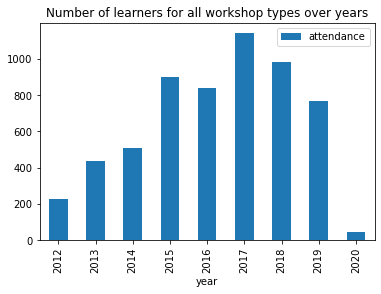

In [195]:
# How many learners attended workshops over years?
attendance_per_year = workshops_df.groupby(['year'])["attendance"].sum().fillna(0).astype("int")
attendance_per_year.index = attendance_per_year.index.astype(int)
print(attendance_per_year)
attendance_per_year.plot(kind='bar', legend=True, title ="Number of learners for all workshop types over years")

      number_of_workshops
year                     
2012                  140
2013                  280
2014                  400
2015                  620
2016                  800
2017                 1040
2018                 1220
2019                 1700
2020                 1060
Estimated total number of learners: number_of_workshops    7260
dtype: int64


<AxesSubplot:title={'center':'Estimated number of attendees over years'}, xlabel='year'>

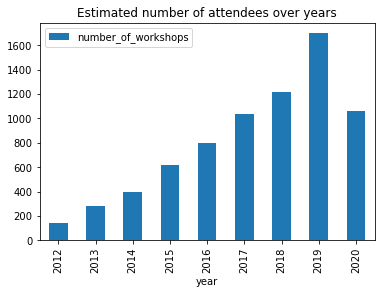

In [196]:
# We do not collect attendance any more, let's estimate as 20 learners per workshop
estimated_attendance_per_year = workshops_per_year*20
print(estimated_attendance_per_year)
print('Estimated total number of learners: ' + str(estimated_attendance_per_year.sum()))
estimated_attendance_per_year.plot(kind='bar', legend=True, title = "Estimated number of attendees over years")

Average workshop attendance: 16

year
2012.0     228
2013.0     439
2014.0     509
2015.0     898
2016.0     839
2017.0    1142
2018.0     985
2019.0     768
2020.0      46
Name: attendance, dtype: int64


<AxesSubplot:title={'center':'Adjusted number of learners for all workshop types over years'}, xlabel='year'>

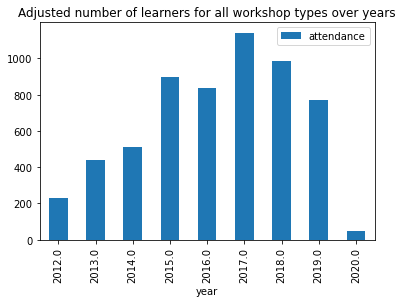

In [197]:
# How many learners attended workshops over years (with adjustments for missing attendance data with average attendance)?

# Disregard TTT workshops as they have attendance capped at 20 most of the times
average_attendance = round(workshops_df[workshops_df["workshop_type"] != "TTT"]["attendance"].mean())
print("Average workshop attendance: " + str(average_attendance) + "\n")
# Adjusted attendance over year data and graph
workshops_df["attendance"].fillna(average_attendance, inplace=True)
attendance_per_year = workshops_df.groupby(['year'])["attendance"].sum().astype("int")
print(attendance_per_year)
attendance_per_year.plot(kind='bar', legend=True, title ="Adjusted number of learners for all workshop types over years")

workshop_type
DC     1420
LC      160
SWC    5080
TTT     460
Name: slug, dtype: int64


<AxesSubplot:title={'center':'Estimated total attendance per workshop type'}, xlabel='workshop_type'>

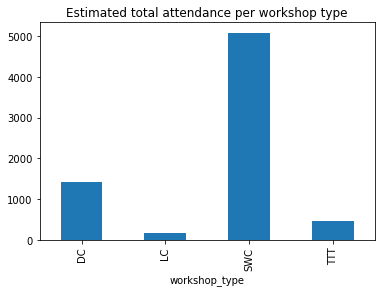

In [198]:
# Estimated total attendance for different workshop types (with estimated 20 attendees per workshop)
# attendance_per_workshop_type = workshops_df.groupby(['workshop_type'])['attendance'].sum().astype("int")
# print(attendance_per_workshop_type)
# attendance_per_workshop_type.plot(kind="bar", title="Total attendance per workshop type")
estimated_attendance_per_workshop_type = workshops_df.groupby(['workshop_type'])['slug'].count()*20
print(estimated_attendance_per_workshop_type)
estimated_attendance_per_workshop_type.plot(kind="bar", title="Estimated total attendance per workshop type")

workshop_type   DC  LC  SWC  TTT
year                            
2012.0           0   0  228    0
2013.0           0   0  439    0
2014.0           0   0  509    0
2015.0          78  59  686   75
2016.0         144   0  635   60
2017.0         284  51  706  101
2018.0         156  54  706   69
2019.0         285   0  468   15
2020.0           0   0   46    0


<AxesSubplot:title={'center':'Attendance at different workshop types over years'}, xlabel='year'>

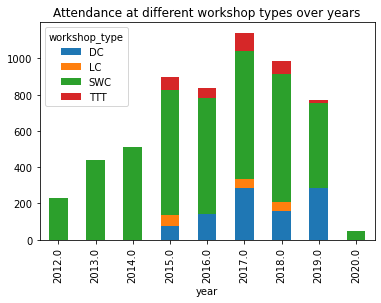

In [199]:
# How many learners attended each of (SWC, DC, LC, TTT) workshops over years (missing data adjusted by average attendance)?
attendance_per_type_per_year = workshops_df.groupby(['workshop_type', 'year'])['attendance'].sum().unstack("workshop_type").fillna(0).astype("int")
print(attendance_per_type_per_year)
attendance_per_type_per_year.plot(kind='bar', stacked=True, title="Attendance at different workshop types over years")

workshop_type  DC  LC  SWC  TTT
year                           
2012            0   0    7    0
2013            0   0   14    0
2014            0   0   20    0
2015            2   1   24    4
2016            7   0   30    3
2017           12   2   33    5
2018           11   2   43    5
2019           24   3   54    4
2020           15   0   29    2


<AxesSubplot:title={'center':'Attendance at different workshop types over years'}, xlabel='year'>

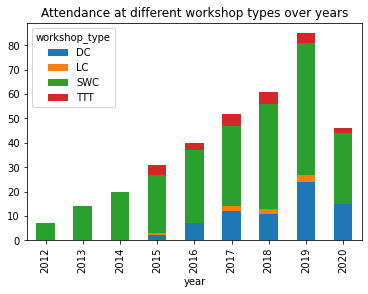

In [200]:
# Estimate how many learners attended each of (SWC, DC, LC, TTT) workshops over years (with 20 learners per workshop estimate)?
estimated_attendance_per_type_per_year = workshops_df.groupby(['workshop_type', 'year'])['slug'].count().unstack("workshop_type").fillna(0).astype("int")
estimated_attendance_per_type_per_year.index = estimated_attendance_per_type_per_year.index.astype(int)
# estimated_attendance_per_type_per_year = estimated_attendance_per_type_per_year * 20
print(estimated_attendance_per_type_per_year)
estimated_attendance_per_type_per_year.plot(kind='bar', stacked=True, title="Attendance at different workshop types over years")

<AxesSubplot:title={'center':'Attendance at SWC workshops'}, xlabel='year'>

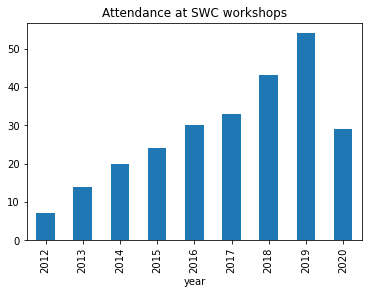

In [201]:
# Estimated attendance just for SWC workshops over years
# Can be done similarly for DC, LC, TTT workshops, this is just an example
estimated_attendance_per_type_per_year["SWC"].plot(kind='bar', title="Attendance at SWC workshops")

                          number_of_workshops
region                                       
London                                     81
Scotland                                   72
South East                                 45
North West                                 37
Yorkshire and The Humber                   25
Eastern                                    22
Wales                                      20
West Midlands                              11
South West                                  8
East Midlands                               6
North East                                  5
Northern Ireland                            2


<AxesSubplot:title={'center':'Workshops per UK region'}, xlabel='region'>

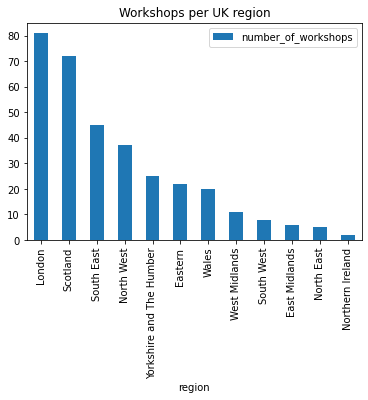

In [202]:
# How many workshops per UK regions?
workshops_per_UK_region = workshops_df['region'].value_counts()
workshops_per_UK_region.index.name = 'region'
workshops_per_UK_region = workshops_per_UK_region.to_frame('number_of_workshops')
print(workshops_per_UK_region)
workshops_per_UK_region.plot(kind='bar', legend=True, title ="Workshops per UK region")

In [203]:
# Let's do a choropleth map of workshops per UK regions
# uk_regions = json.load(open(UK_REGIONS_FILE, encoding='utf-8-sig'))
# workshops_map = helper.generate_choropleth_map(workshops_df[~workshops_df['region'].isnull()], uk_regions, "workshops")
# workshops_map

In [204]:
# Let's draw a clustered map of all workshop locations
workshops_map = helper.generate_map_with_clustered_markers(workshops_df[~workshops_df['longitude'].isnull()])
workshops_map

/Users/alex/work/SSI/Code/carpentry-data-analysis/lib/helper.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["latitude","longitude"], how="any", axis=0, inplace=True)


In [206]:
# Save all analyses into an Excel spreadsheet
if not os.path.exists(ANALYSES_DIR):
    os.makedirs(ANALYSES_DIR)

workshops_file_name = os.path.basename(workshops_file)
workshops_file_name_without_extension = re.sub('\.csv$', '', workshops_file_name.strip())
workshop_analyses_excel_file = ANALYSES_DIR + "analysed_" + workshops_file_name_without_extension + '_from_ipynb.xlsx'

excel_writer = pd.ExcelWriter(workshop_analyses_excel_file, engine='xlsxwriter')

workshops_df.to_excel(excel_writer, sheet_name="carpentry_workshops", index=False)

# Workshops per year
workshops_per_year.to_excel(excel_writer, sheet_name='workshops_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_year']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_year', 1, 0, len(workshops_per_year.index), 0],
        'values': ['workshops_per_year', 1, 1, len(workshops_per_year.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per year'})
worksheet.insert_chart('I2', chart)
worksheet.write(0, 3, "Total number of workshops: " + str(total_workshops))

# Workshops per type   
workshops_per_type.to_excel(excel_writer, sheet_name='workshops_per_type', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_type']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_type', 1, 0, len(workshops_per_type.index), 0],
        'values': ['workshops_per_type', 1, 1, len(workshops_per_type.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Workshop type'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops of different types'})
worksheet.insert_chart('I2', chart)
    
# Workshops per type per year
workshops_per_type_per_year.to_excel(excel_writer, sheet_name='workshops_per_type_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_type_per_year']
chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
for i in range(1, len(workshops_per_type_per_year.columns) + 1):
    chart.add_series({
            'name': ['workshops_per_type_per_year', 0, i],
            'categories': ['workshops_per_type_per_year', i, 0, len(workshops_per_type_per_year.index), 0],
            'values': ['workshops_per_type_per_year', 1, i, len(workshops_per_type_per_year.index), i],
            'gap': 2,
        })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops of different types over years'})
worksheet.insert_chart('B20', chart)

# Workshops per host
workshops_per_host.to_excel(excel_writer, sheet_name='workshops_per_host', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_host']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_host', 1, 0, len(workshops_per_host.index), 0],
        'values': ['workshops_per_host', 1, 1, len(workshops_per_host.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Host institution'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per host'})
worksheet.insert_chart('I2', chart)

# Workshop attendance per year
attendance_per_year.to_excel(excel_writer, sheet_name='attendance_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['attendance_per_year']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['attendance_per_year', 1, 0, len(attendance_per_year.index), 0],
        'values': ['attendance_per_year', 1, 1, len(attendance_per_year.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of attendees', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of attendees per year (with estimates for missing data)'})
worksheet.insert_chart('I2', chart)

# Online vs in-person worshops
online_vs_inperson_workshops.to_excel(excel_writer, sheet_name='online_vs_inperson_workshops', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['online_vs_inperson_workshops']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['online_vs_inperson_workshops', 1, 0, len(online_vs_inperson_workshops.index), 0],
        'values': ['online_vs_inperson_workshops', 1, 1, len(online_vs_inperson_workshops.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'online_vs_inperson'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of online and in-persnon workshops)'})
worksheet.insert_chart('I2', chart)

# Workshop attendance per workshop type
estimated_attendance_per_workshop_type.to_excel(excel_writer, sheet_name='attendance_per_type', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['attendance_per_type']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['attendance_per_type', 1, 0, len(estimated_attendance_per_workshop_type.index), 0],
        'values': ['attendance_per_type', 1, 1, len(estimated_attendance_per_workshop_type.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Workshop type'})
chart.set_y_axis({'name': 'Number of attendees', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of attendees per workshop type (with estimates of 20 attendees per workshop)'})
worksheet.insert_chart('I2', chart)

# Workshop attendance per workshop type per year
estimated_attendance_per_type_per_year.to_excel(excel_writer, sheet_name='attendance_per_type_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['attendance_per_type_per_year']
chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
for i in range(1, len(estimated_attendance_per_type_per_year.columns) + 1):
    chart.add_series({
            'name': ['attendance_per_type_per_year', 0, i],
            'categories': ['attendance_per_type_per_year', i, 0, len(estimated_attendance_per_type_per_year.index), 0],
            'values': ['attendance_per_type_per_year', 1, i, len(estimated_attendance_per_type_per_year.index), i],
            'gap': 2,
        })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Attendance', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Attendance at workshops of different types over years (with estimated 20 attendees per workshop)'})
worksheet.insert_chart('B20', chart)

excel_writer.save()
print("Saved workshop analyses in " + workshop_analyses_excel_file)

Saved workshop analyses in data/analyses/analysed_processed_carpentry_workshops_UK_2020-12-08_redash_from_ipynb.xlsx
